In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jena-climate-2009-2016/jena_climate_2009_2016.csv


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

import warnings 
warnings.filterwarnings('ignore')

# **1-Load Data**

In [3]:
fname = os.path.join('/kaggle/input/jena-climate-2009-2016/jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Parsing the data
    </font>
</div>

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

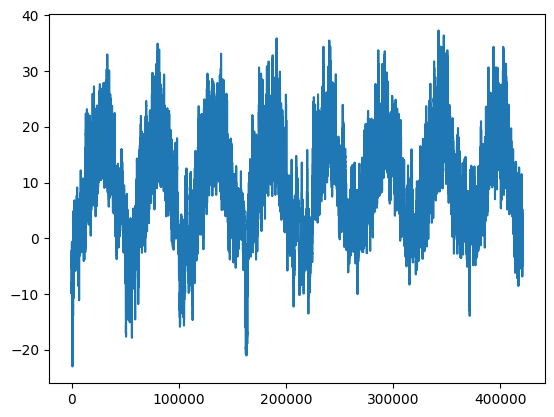

In [5]:
plt.plot(range(len(temperature)), temperature);

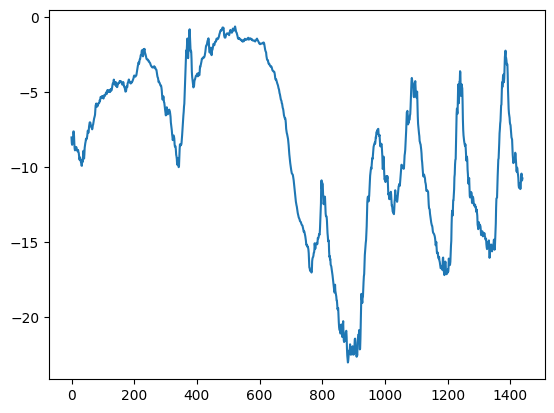

In [6]:
plt.plot(range(1440), temperature[:1440]);

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


# **2-Preparing the Data**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Normalizing the data
    </font>
</div>

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Instantiating datasets for training, validation, and testing
    </font>
</div>

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


# **3- 1D convolutional model**

In [12]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 12, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 6, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - loss: 32.3676 - mae: 4.3706 - val_loss: 15.1042 - val_mae: 3.1028
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 18.0702 - mae: 3.3427 - val_loss: 17.3684 - val_mae: 3.2829
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 15.9720 - mae: 3.1519 - val_loss: 14.1959 - val_mae: 2.9772
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 14.6496 - mae: 3.0257 - val_loss: 13.8066 - val_mae: 2.9269
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 13.7001 - mae: 2.9230 - val_loss: 14.9158 - val_mae: 3.0376
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 13.0338 - mae: 2.8499 - val_loss: 14.7407 - val_mae: 3.0380
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 12.4752 - mae: 2.7896 - val_loss: 14.8560 - val_mae: 3.0369
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 11.9892 - mae: 2.7289 - val_loss: 14.4454 - val_mae: 2.9948
Epoch 9/10
819/819 ━━━━━

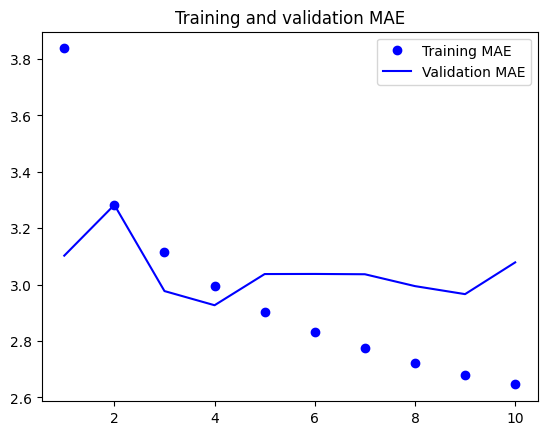

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **4- A simple LSTM-based model**

In [14]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - loss: 78.3910 - mae: 6.7821 - val_loss: 13.3650 - val_mae: 2.7660
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - loss: 12.1933 - mae: 2.6906 - val_loss: 9.4824 - val_mae: 2.3883
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - loss: 9.7833 - mae: 2.4302 - val_loss: 9.0801 - val_mae: 2.3264
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 9.0254 - mae: 2.3393 - val_loss: 9.2117 - val_mae: 2.3606
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 8.5146 - mae: 2.2757 - val_loss: 9.5279 - val_mae: 2.3954
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - loss: 8.1700 - mae: 2.2286 - val_loss: 9.3563 - val_mae: 2.3817
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 7.9003 - mae: 2.1898 - val_loss: 9.4987 - val_mae: 2.3938
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - loss: 7.6682 - mae: 2.1570 - val_loss: 9.5721 - val_mae: 2.4031
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

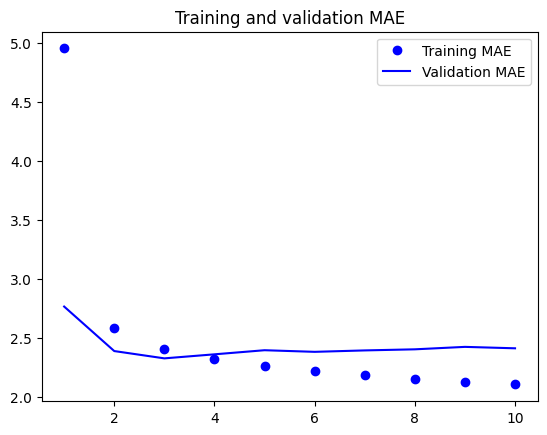

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **5- bidirectional RNNs**

In [16]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 89ms/step - loss: 53.3462 - mae: 5.3832 - val_loss: 10.6839 - val_mae: 2.5295
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - loss: 9.8970 - mae: 2.4620 - val_loss: 9.6040 - val_mae: 2.4062
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 8.6972 - mae: 2.2967 - val_loss: 10.1693 - val_mae: 2.4787
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 8.1546 - mae: 2.2238 - val_loss: 10.0705 - val_mae: 2.4572
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - loss: 7.7669 - mae: 2.1709 - val_loss: 10.2644 - val_mae: 2.4812
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - loss: 7.4388 - mae: 2.1247 - val_loss: 10.2220 - val_mae: 2.4709
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - loss: 7.2138 - mae: 2.0943 - val_loss: 10.2140 - val_mae: 2.4756
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - loss: 6.9391 - mae: 2.0571 - val_loss: 10.3396 - val_mae: 2.4926
Epoch 9/10
819/819 ━━━━━━━━━━━━━

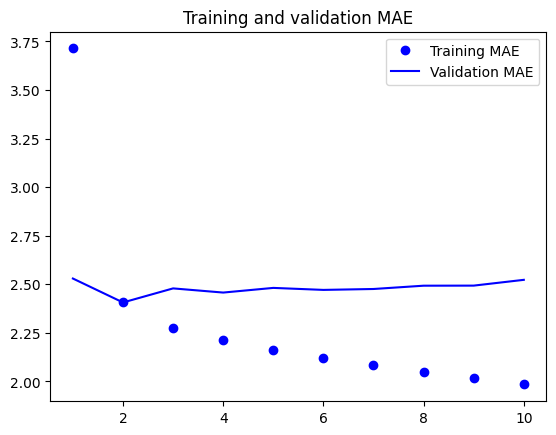

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()